In [78]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as sk

In [79]:
xx = pd.read_csv('covid_serological_results.csv')
# 0 -> negative, 1 -> uncertain, 2 -> positive.
# We want results with only 0 and 1
xx = xx[xx.COVID_swab_res != 1]  # so we remove uncertain results
xx.COVID_swab_res[xx.COVID_swab_res == 2] = 1  # and 2 is then replaced with 1
swab = xx.COVID_swab_res.values
Test1 = xx.IgG_Test1_titre.values
Test2 = xx.IgG_Test2_titre.values

array([[<Axes: xlabel='COVID_swab_res', ylabel='COVID_swab_res'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='COVID_swab_res'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='COVID_swab_res'>],
       [<Axes: xlabel='COVID_swab_res', ylabel='IgG_Test1_titre'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='IgG_Test1_titre'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='IgG_Test1_titre'>],
       [<Axes: xlabel='COVID_swab_res', ylabel='IgG_Test2_titre'>,
        <Axes: xlabel='IgG_Test1_titre', ylabel='IgG_Test2_titre'>,
        <Axes: xlabel='IgG_Test2_titre', ylabel='IgG_Test2_titre'>]],
      dtype=object)

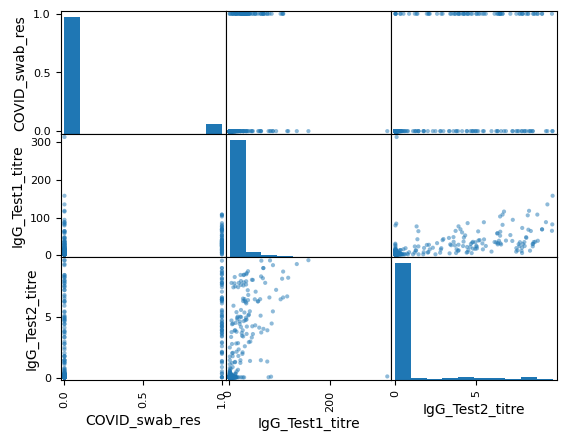

In [80]:
pd.plotting.scatter_matrix(xx)

In [81]:
xx.describe()

,COVID_swab_res,IgG_Test1_titre,IgG_Test2_titre
count,862.000000,862.000000,862.000000
mean,0.082367,9.374849,0.803515
std,0.275082,20.431089,2.064172
min,0.000000,2.500000,0.000000
25%,0.000000,2.500000,0.020000
50%,0.000000,2.500000,0.030000
75%,0.000000,5.175000,0.070000
max,1.000000,314.000000,9.690000


In [82]:
x = Test2
y = swab
x0 = x[y == 0]  # Test results for healthy patients
x1 = x[y == 1]  # Test results for ill patients
Nn = sum(y == 0)  # Number of healthy patients
Np = sum(y == 1)  # Number of ill patients
mean = np.mean(y, axis=0)
max_test = max(x)
thresh = mean * max_test
n0 = np.sum(x0 < thresh)  # Number of true negatives
n1 = np.sum(x1 > thresh)  # Number of true positives
spec = n0 / Nn
sens = n1 / Np

Find sensitivity and specificity [2]

In [83]:
def ss_vs_threshold(x, y, threshold_values):
    x0 = x[y == 0]  # Test results for healthy patients
    x1 = x[y == 1]  # Test results for ill patients
    Nn = sum(y == 0)  # Number of positive patients
    Np = sum(y == 1)  # Number of ill patients
    n0 = np.array([np.sum(x0 < thresh) for thresh in threshold_values])
    n1 = np.array([np.sum(x1 > thresh) for thresh in threshold_values])
    specificity_values = n0 / Nn
    sensitivity_values = n1 / Np
    return {'thresholds': threshold_values,
            'specificities': specificity_values,
            'sensitivities': sensitivity_values}

In [84]:
thresholds = np.unique(np.append(0, [x[i] for i in np.argsort(x)]))
tss = ss_vs_threshold(x, y, thresholds)

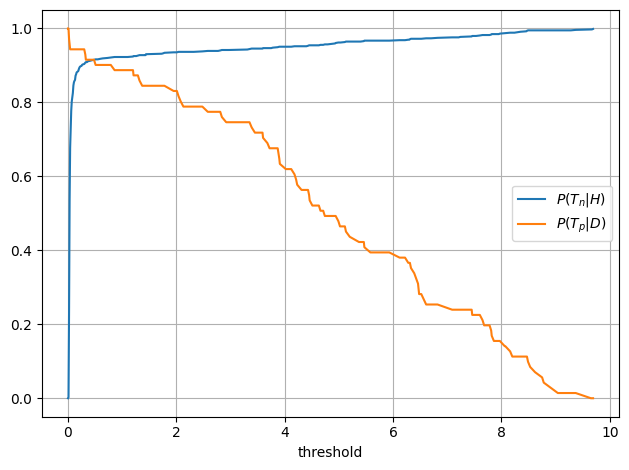

In [85]:
plt.figure()
plt.plot(thresholds, tss['specificities'])
plt.plot(thresholds, tss['sensitivities'])
labels = ['$P(T_n|H)$', '$P(T_p|D)$']
plt.xlabel('threshold')
plt.legend(labels)
plt.grid()
plt.tight_layout()
plt.show()

ROC [1]

[1.         0.99747155 0.76485461 0.4664981  0.32237674 0.27180784
 0.22250316 0.19721871 0.18584071 0.17446271 0.15423515 0.14538559
 0.14159292 0.13906448 0.12768647 0.12389381 0.11883692 0.11757269
 0.11504425 0.10998736 0.10619469 0.10366625 0.10240202 0.1011378
 0.09860936 0.09734513 0.09608091 0.09228824 0.09102402 0.09102402
 0.0897598  0.08849558 0.08723135 0.08596713 0.08470291 0.08343869
 0.08343869 0.08217446 0.08091024 0.07964602 0.0783818  0.07711757
 0.07711757 0.07585335 0.07458913 0.07458913 0.07332491 0.07206068
 0.07206068 0.07206068 0.06953224 0.06826802 0.06700379 0.06573957
 0.06447535 0.06447535 0.06321113 0.06321113 0.06321113 0.06321113
 0.0619469  0.06068268 0.06068268 0.05941846 0.05815424 0.05815424
 0.05815424 0.05689001 0.05562579 0.05436157 0.05436157 0.05436157
 0.05309735 0.05309735 0.05309735 0.05309735 0.05183312 0.0505689
 0.04930468 0.04930468 0.04930468 0.04930468 0.04804046 0.04804046
 0.04804046 0.04804046 0.04804046 0.04677623 0.04551201 0.045512

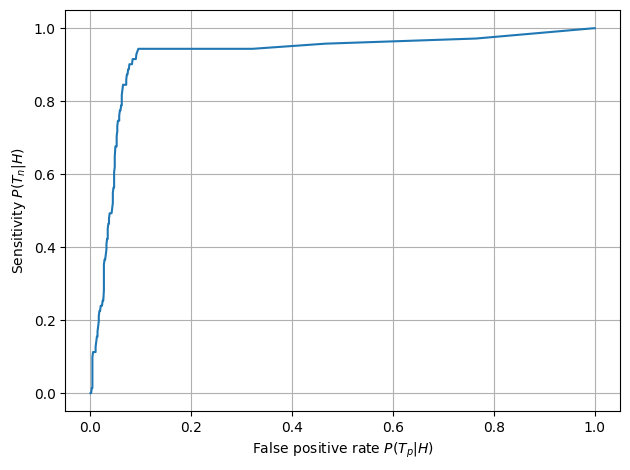

In [92]:
fpr = 1 - tss['specificities']
print(fpr)
plt.figure()
plt.plot(fpr, tss['sensitivities'])
plt.xlabel('False positive rate $P(T_p|H)$')
plt.ylabel('Sensitivity $P(T_n|H)$')
plt.grid()
plt.tight_layout()
plt.show()

In [88]:
def integral_diy(x, y):
    assert len(x) == len(y)
    N = len(x)
    area = 0
    i_sorted = np.argsort(x)
    for i in range(0, N - 1):
        dx = x[i_sorted[i + 1]] - x[i_sorted[i]]
        yi = (y[i_sorted[i]] + y[i_sorted[i + 1]]) / 2
        area += yi * dx
    return area

In [89]:
ROC_AUC = integral_diy(fpr, tss['sensitivities'])
print(f'Area under ROC (AUC): {ROC_AUC}')

Area under ROC (AUC): 0.9239240754260073


Check

In [90]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score

check_fpr, check_tpr, check_thresh = metrics.roc_curve(y, x, pos_label=1)
check_AUC = roc_auc_score(y, x)

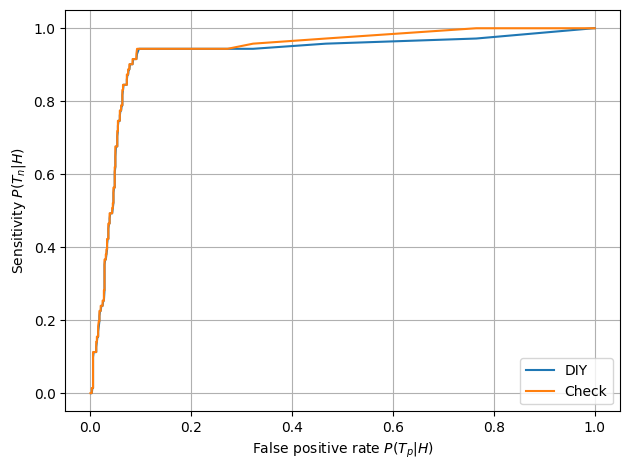

In [93]:
plt.figure()
plt.plot(fpr, tss['sensitivities'])
plt.plot(check_fpr, check_tpr)
plt.xlabel('False positive rate $P(T_p|H)$')
plt.ylabel('Sensitivity $P(T_n|H)$')
labels = ['DIY', 'Check']
plt.legend(labels)
plt.grid()
plt.tight_layout()
plt.show()

How to set the threshold [1]

In [97]:
def lines_intersection_2p_temp(x1, x2, l1ys, l2ys):
    print(x1, x2)
    dx = x2 - x1
    return dx * (l2ys[0] - l1ys[0]) / (l1ys[1] + l2ys[1] - l1ys[0] - l2ys[0])

In [98]:
thresholds_sorted = np.argsort(np.abs(tss['specificities'] - tss['sensitivities']))
best_ts = [thresholds[thresholds_sorted[0]],  thresholds[thresholds_sorted[1]]]
print()
best_threshold = lines_intersection_2p_temp(x1=best_ts[0],
                                            x2=best_ts[1],
                                            l1ys=tss['specificities'],
                                            l2ys=tss['sensitivities'])
print(best_threshold)


0.48 0.44
-15.819999999999371
